In [23]:
model.inputs

[<tf.Tensor 'conv2d_1_input:0' shape=(?, 28, 28, 1) dtype=float32>]

In [ ]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):

    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

#Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, "model", "tf_model.pb", as_text=False)

In [24]:
MODEL_NAME = 'mnist_convnet'
def export_model(model, input_node_names, output_node_name):
    tf.train.write_graph(K.get_session().graph_def, 'Documents', \
        MODEL_NAME + '_graph.pbtxt')

    tf.train.Saver().save(K.get_session(), 'Documents/' + MODEL_NAME + '.chkp')

    freeze_graph.freeze_graph('Documents/' + MODEL_NAME + '_graph.pbtxt', None, \
        False, 'Documents/' + MODEL_NAME + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        'Documents/frozen_' + MODEL_NAME + '.pb', True,"")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('Documents/frozen_' + MODEL_NAME + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('Documents/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")
    
def main():
    if not path.exists('Documents'):
        os.mkdir('Documents')
    export_model(model, "conv2d_1_input", "dense_2/Softmax")
if __name__ == '__main__':
    main()

IndexError: list index out of range

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [1]:
# Importing libraries
import numpy as np
import pandas as pd

import tensorflow as tf
import keras as kr

# modules for neural network
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense
from keras.layers import Input,Dropout,Flatten
from keras import backend as K

from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

import os
import os.path as path

import matplotlib.pyplot as plt 

C:\Users\bhavy\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\bhavy\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\bhavy\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\bhavy\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

## Importing Data

In [2]:
# Importing data
from keras.datasets import mnist
(train_x,train_y),(test_x,test_y) = mnist.load_data()

In [3]:
print("train data shape: "+str(train_x.shape))
print("test data shape: "+str(test_x.shape))

train data shape: (60000, 28, 28)
test data shape: (10000, 28, 28)


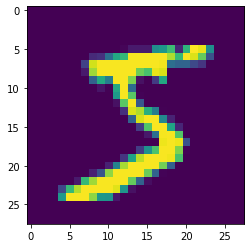

In [4]:
plt.imshow(train_x[0])

## Shaping data
the data is altered or changed so that it is easier for the neural netwrok to be trained

In [5]:
# changing training and test features
train_x = train_x.reshape(train_x.shape[0],28,28,1)
test_x = test_x.reshape(test_x.shape[0],28,28,1)
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x = train_x/225
test_x = test_x/225

train_y = kr.utils.to_categorical(train_y,10)
test_y = kr.utils.to_categorical(test_y,10)

## Creating CNN Model

In [6]:
# Now Creating a convolutional-neural network
model = Sequential()

# Adding Layers
model.add(Conv2D(filters=64,kernel_size=3,padding='same',strides=1,input_shape=[28,28,1],activation='relu'))
model.add(MaxPooling2D(pool_size=2,padding='same',strides=2))

model.add(Conv2D(filters=128,kernel_size=3,padding='same',strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=2,padding='same',strides=2))

model.add(Conv2D(filters=256,kernel_size=3,padding='same',strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=2,padding='same',strides=2))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [7]:
# Compiling model
model.compile(loss=categorical_crossentropy,optimizer=Adadelta(),metrics=['accuracy'])

In [8]:
# Training model
batch_size = 128
epochs = 1
model.fit(train_x,train_y,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(test_x,test_y))


Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 359s 6ms/step - loss: 0.2122 - accuracy: 0.9319 - val_loss: 0.0362 - val_accuracy: 0.9883


## Exporting Model

In [9]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
model.save("trained_model.h5",include_optimizer=False)

In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model_file('trained_model.h5')

tflite_model=converter.convert()

open("converted_model.tflite","wb").write(tflite_model)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.


18303576